# **Analyze the data from scratch**
steps

## Load Libraries

In [19]:
# LOAD LIBRARIES
library(Seurat)
library(tidyverse)
library(future)
library(ggplot2)
library(dplyr)
library(presto)
library(cowplot)

library(enrichR)
library(GPTCelltype)
library(openai)

## Setup

In [2]:
# SET UP NAMES
timepoints <- c("23days", "1month", "1.5month", "2month", "3month", "4month", "5month", "6month")
housekeeping_genes <- c("ACTB", "DLG4")
genes_of_interest <- c("SRCIN1", "KIAA1217", "CIT")
path_to_data <- "/sharedFolder/Data/"

name_new_dir_results <- paste(getwd(), "/Results", sep = "")
if (!dir.exists(name_new_dir_results)) {
    dir.create(name_new_dir_results)
}

name_new_dir_partial <- paste(getwd(), "/Partial", sep = "")
if (!dir.exists(name_new_dir_partial)) {
    dir.create(name_new_dir_partial)
}

In [3]:
for (a in 1:8) {
    name_new_dir <- paste(name_new_dir_partial, "/", timepoints[a], sep="")     
    if (!dir.exists(name_new_dir)) {
        dir.create(name_new_dir)
    }
    name_new_dir <- paste(name_new_dir_results, "/", timepoints[a], sep="")     
    if (!dir.exists(name_new_dir)) {
        dir.create(name_new_dir)
    }  
}

## Define functions

### load.data(time_point)
* LOAD DATA
* NORMALIZE
* FIND VARIABLE FEATURES
* SCALE DATA

In [4]:
load.data <- function(file_name = timepoints[time_point], save = TRUE, res, n_dim) {
    char_res <- as.character(res)
    if (grepl("\\.", char_res)) {char_res <- gsub("\\.", "_", char_res)}
    param <- paste0("_res_", char_res, "_dim_", n_dim)
    print(paste("Loading data for time point:", file_name))

    # Load the data
    sc_data <- Read10X(data.dir = paste(path_to_data, "expression_", file_name, sep = ""), gene.column = 1)

    # Create Seurat object
    sc_data <- CreateSeuratObject(counts = sc_data, min.cells = 3, min.features = 500, project = file_name, names.delim = "-", names.field = 2)

    # Normalize the data
    sc_data <- NormalizeData(sc_data, normalization.method = "LogNormalize", scale.factor = 1e6)

    # Find variable features
    sc_data <- FindVariableFeatures(sc_data, selection.method = "mvp", nfeatures = 2000)

    # Scale the data
    sc_data <- ScaleData(sc_data)

    # Save the Scaled data
    if (save) {
        name_new_dir <- paste(name_new_dir_partial, "/", file_name, "/cluster", param, sep = "")
        if (!dir.exists(name_new_dir)) {dir.create(name_new_dir)}
        
        print(paste("Saving PCA for time point", file_name, "in", name_new_dir))
        save(sc_data, file = paste(name_new_dir, "/Scaled_", file_name, param, ".Robj", sep = ""))
    }
    
    return(sc_data)
}

### PCA.cluster(x = sc_data, res)
* Run PCA
* Cluster the cells

In [5]:
PCA.cluster <- function(x = sc_data, file_name = timepoints[time_point], res = 1, n_dim = 40, 
                        save = TRUE) {
    char_res <- as.character(res)
    if (grepl("\\.", char_res)) {char_res <- gsub("\\.", "_", char_res)}
    param <- paste0("_res_", char_res, "_dim_", n_dim)
    print(paste("Running PCA and clustering for time point:", file_name))
    
    # PCA
    x <- RunPCA(x, npcs = n_dim+10, verbose = FALSE)
    #print(ElbowPlot(object = x, ndims = 50))

    # Cluster the cells
    x <- FindNeighbors(x, dims = 1:n_dim)
    x <- FindClusters(x, resolution = res)
    
    print(table(Idents(x)))

    # Save the PCA plot
    if (save) {
        name_new_dir <- paste(name_new_dir_partial, "/", file_name, "/cluster", param, sep="")
        if (!dir.exists(name_new_dir)) {dir.create(name_new_dir)} 
    
        print(paste("Saving PCA for time point", file_name, "in", name_new_dir))
        save(x, file = paste(name_new_dir, "/PCA_res_", res, "_dim_", n_dim, "_", file_name, ".Robj", sep=""))
    }
    return(x)
}

### cluster.markers(x = sc_data)
* find all markers for every cluster compared to all remaining cells

In [6]:
# FIND ALL MARKERS
cluster.markers <- function(x, file_name = timepoints[time_point],
                            save = TRUE, res, n_dim) {
    char_res <- as.character(res)
    if (grepl("\\.", char_res)) {char_res <- gsub("\\.", "_", char_res)}
    param <- paste0("_res_", char_res, "_dim_", n_dim)
    print(paste("Finding all markers for time point:", file_name))

    # Find all markers for every cluster compared to all remaining cells
    markers <- FindAllMarkers(x,
                                        only.pos = TRUE,   # Considera solo i marker espressi positivamente
                                        min.pct = 0.25,    # Percentuale minima di espressione nelle cellule del cluster
                                        logfc.threshold = 0.25)  # Soglia minima di LogFC
    
    # Save the markers
    if (save) {
        name_new_dir <- paste(name_new_dir_partial, "/", file_name, "/cluster", param, sep="")     
        if (!dir.exists(name_new_dir)) {dir.create(name_new_dir)} 
        
        print(paste("Saving cluster markers for time point", file_name, "in", name_new_dir))
        save(markers, file = paste(name_new_dir, "/cluster_markers_", file_name, param, ".Robj", sep=""))
    }
        
    return(markers)
}

### Reload from partials
* load.sc_data(time_point) = up to scaleData()
* load.cluster(time_point, res) = clustered
* load.markers(time_point) = markers

In [7]:
# RELOAD DATA
load.sc_data <- function(file_name = timepoints[time_point]) {
    name_new_dir <- paste(name_new_dir_partial, "/", file_name, sep = "")
    load(paste(name_new_dir, "/cluster_markers_", file_name, ".Robj", sep = ""))
    return(sc_data)
}

load.clusters <- function(file_name = timepoints[time_point], res) {
    name_new_dir <- paste(name_new_dir_partial, "/", file_name, sep = "")
    load(paste(name_new_dir, "/PCA_res_", res, "_", file_name, ".Robj", sep = ""))
    return(sc_data)
}

load.markers <- function(file_name = timepoints[time_point]) {
    name_new_dir <- paste(name_new_dir_partial, "/", file_name, sep = "")
    load(paste(name_new_dir, "/cluster_markers_", file_name, ".Robj", sep = ""))
    return(cluster_markers)
}

### de.genes(genes_oi)
* finds whether one or more genes of interest are differentialy expressed in the clusters
* if no genes are specified this function assumes that **genes_oi** is **genes_of_interest**

In [8]:
# FIND DIFFERENTIALLY EXPRESSED GENES
de.genes <- function(genes_oi = genes_of_interest, c_m = cluster_markers, file_name = timepoints[time_point], 
                     save = TRUE, res, n_dim) {
    char_res <- as.character(res)
    if (grepl("\\.", char_res)) {char_res <- gsub("\\.", "_", char_res)}
    param <- paste0("_res_", char_res, "_dim_", n_dim)
    print(paste("Finding differentially expressed genes for time point:", file_name))

    # Find differentially expressed genes
    de_genes <- c_m %>% filter(gene %in% genes_oi)
    print(de_genes)

    # Save the DE genes
    if (save) {
        name_new_dir <- paste(name_new_dir_results, "/", file_name, "/cluster", param, sep = "")
        if (!dir.exists(name_new_dir)) {dir.create(name_new_dir)}
        
        print(paste("Saving differentially expressed genes for time point", file_name, "in", name_new_dir))
        write.csv(de_genes, file = paste(name_new_dir, "/de_genes_", file_name, param, ".csv", sep = ""))
    }
    
    return(de_genes)
}

## Violin Plots

### Violin genes-clusters

In [9]:
vin.genes <- function(X, file_name = timepoints[time_point]) {
    VlnPlot(
        sc_data, 
        features = X, 
        group.by = "seurat_clusters", 
        layer = "data"
    ) +
    labs(
        title = paste(file_name, "-", X),
        x = "Cluster"
    ) +
    theme(
        legend.position = "none"
    )
}

In [10]:
vin.genes.log <- function(X) {
    VlnPlot(
        sc_data, 
        features = X, 
        group.by = "seurat_clusters", 
        layer = "data",
        log = TRUE
    ) +
    labs(
        x = "Cluster",
        y = "Expression Level (log)"
    ) +
    theme(
        legend.position = "none"
    )
}

In [11]:
vin.genes.comb <- function (
    X, 
    name, 
    file_name = timepoints[time_point], 
    log = FALSE, 
    save = TRUE,
    res, 
    n_dim
) {
    char_res <- as.character(res)
    if (grepl("\\.", char_res)) {char_res <- gsub("\\.", "_", char_res)}
    param <- paste0("_res_", char_res, "_dim_", n_dim)    

    if (length(log) != 1) stop("log must be a single logical value")
    if (log) {
        violin <- lapply(X, vin.genes.log)
    } else {
        violin <- lapply(X, vin.genes)
    }
    
    if (name == 1) {
        name <- "genes_of_interest"
    } else if (name == 2) {
        name <- "housekeeping_genes"
    }

    logarithmic <- ifelse(log, "logarithmic", "")
    print(
        paste(
            "Violin", logarithmic, " plot for", name, 
            "in",
            file_name
        )
    )
    
    name_prefix <- ifelse(log, "(log10)", "")
    
    combined <- plot_grid(plotlist = violin, ncol = 1)
    title <- ggdraw() + draw_label(paste(file_name,"- Genes of interest", name_prefix), fontface = 'bold', size = 14)
    comp_plot <- plot_grid(title, combined, ncol = 1, rel_heights = c(0.1, 2))

    # Save
    if (save) {
        folder <- paste0("Results/", file_name, "/cluster", param, "/Violin_genes")
        if (!dir.exists(folder)) {dir.create(folder)}
        
        file_prefix <- ifelse(log, "log10_", "")
        ggsave(
            paste0(
                folder,
                "/", file_prefix, "violin_plot_",
                name, "_",
                file_name, param,
                ".png"
            ),
            plot = comp_plot,
            width = 1920, height = 1080*length(X), units = "px"
        )
    }

    #print(comp_plot)
    return(comp_plot)
}

### Violin ratio-clusters

In [12]:
vin.ratio <- function(
    sc_data,
    gene_oi, 
    housekeeping, 
    file_name = timepoints[time_point], 
    log = FALSE, 
    save = TRUE,
    res, 
    n_dim
) {
    char_res <- as.character(res)
    if (grepl("\\.", char_res)) {char_res <- gsub("\\.", "_", char_res)}
    param <- paste0("_res_", char_res, "_dim_", n_dim)
    logarithmic <- ifelse(log, "logarithmic", "")
    print(
        paste(
            "Plotting the", logarithmic, "ratio violin between",
            gene_oi,
            "and",
            housekeeping,
            "in",
            file_name
        )
    )
    
    # Extract normalized data
    exprs <- FetchData(sc_data, vars = c(gene_oi, housekeeping), slot = "data")
    
    # Compute ratio
    exprs$ratio <- exprs[[gene_oi]] / exprs[[housekeeping]]

    # Add cluster info
    exprs$cluster <- Idents(sc_data)

    loggi <- ifelse(log, "(log10)", "")
    
    # Plot violin
    vin_ratio <- ggplot(exprs, aes(x = cluster, y = ratio)) +
        geom_violin(trim = FALSE, fill = "#56B4E9") +
        labs(
            title = paste(file_name, "-", gene_oi, "/", housekeeping, loggi),
            x = "Cluster",
            y = paste(gene_oi, "/", housekeeping, loggi)
        ) +
        theme_classic() +
        theme(legend.position = "none")

    if (log) {
        vin_ratio <- vin_ratio + scale_y_log10()
    }

    # Save
    if (save) {
        folder <- paste0("Results/", file_name, "/cluster", param, "/Violin_ratio")
        if (!dir.exists(folder)) {dir.create(folder)}
        
        file_prefix <- ifelse(log, "log10_", "")
        ggsave(
            paste0(
                folder,
                "/", file_prefix, "violin_plot_",
                gene_oi, "-", housekeeping, "_ratio_",
                file_name, param,
                ".png"
            ),
            plot = vin_ratio,
            width = 1920, height = 1080, units = "px"
        )
    }

    #print(vin_ratio)
    return(vin_ratio)
}

### All Violin plots

In [13]:
vin.all <- function(
    sc_data,
    g_oi,
    hk,
    file_name = timepoints[time_point],
    save = TRUE,
    res, 
    n_dim
) {
    vin.genes.comb(X = g_oi, name = 1, file_name = file_name, res = res, n_dim = n_dim, log = FALSE)
    vin.genes.comb(X = g_oi, name = 1, file_name = file_name, res = res, n_dim = n_dim, log = TRUE)

    vin.genes.comb(X = hk, name = 2, file_name = file_name, res = res, n_dim = n_dim, log = FALSE)
    vin.genes.comb(X = hk, name = 2, file_name = file_name, res = res, n_dim = n_dim, log = TRUE)

    for (i in 1:length(g_oi)) {
        for (j in 1:length(hk)) {
            # linear
            vin.ratio(
                sc_data, 
                gene_oi = g_oi[i],
                housekeeping = hk[j],
                file_name = file_name,
                log = FALSE,
                save = save,
                res = res, 
                n_dim = n_dim
            )
            
            # log
            vin.ratio(
                sc_data, 
                gene_oi = g_oi[i],
                housekeeping = hk[j],
                file_name = file_name,
                log = TRUE,
                save = TRUE,
                res = res, 
                n_dim = n_dim
            )
        }
    }
}

## Comparison

In [14]:
comparison.plot <- function(
    gene_oi = genes_of_interest[goi], 
    housekeeping = housekeeping_genes[hk], 
    file_name = timepoints[time_point], 
    log = FALSE,
    save = TRUE,
    res, 
    n_dim
) {
    char_res <- as.character(res)
    if (grepl("\\.", char_res)) {char_res <- gsub("\\.", "_", char_res)}
    param <- paste0("_res_", char_res, "_dim_", n_dim)
    genes <- c(gene_oi, housekeeping)
    logarithmic <- ifelse(log, "logarithmic", "")
    print(
        paste(
            "Plotting the", logarithmic, "ratio between",
            genes[1],
            "and",
            genes[2],
            "in",
            file_name
        )
    )
    
    expression_data <- FetchData(sc_data, vars = genes)
    expression_data$cluster <- sc_data$seurat_clusters[colnames(sc_data)]
    expression_data$goi_hk_ratio <- expression_data[[1]]/expression_data[[2]]
    
    if (log) {
        comp_plot <- ggplot(
            expression_data, 
            aes(x = goi_hk_ratio, fill = cluster)
        ) + 
        geom_histogram(
            binwidth = 0.2, position = "dodge", alpha = 0.7, 
            aes(y = after_stat(count) + 1)
        ) + 
        labs(
            title = paste0(
                file_name, 
                " - Histogram (log10) of ", 
                genes[1], "/", genes[2], 
                " Ratio by Cluster"
            ), 
            x = paste0(genes[1], "/", genes[2], " Ratio"), 
            y = "Number of Cells (+1, log10 scale)"
        ) + 
        theme_minimal() + 
        scale_fill_manual(values = rainbow(length(unique(expression_data$cluster))))

        
    } else {
        comp_plot <- ggplot(
            expression_data, 
            aes(x = goi_hk_ratio, fill = cluster)
        ) + 
        geom_histogram(
            binwidth = 0.2, position = "dodge", alpha = 0.7, 
            aes(y = after_stat(count))
        ) + 
        labs(
            title = paste0(
                file_name, 
                " - Histogram of ", 
                genes[1], "/", genes[2], 
                " Ratio by Cluster"
            ), 
            x = paste0(genes[1], "/", genes[2], " Ratio"), 
            y = "Number of Cells"
        ) + 
        theme_minimal() + 
        scale_fill_manual(values = rainbow(length(unique(expression_data$cluster))))
    }

    if (log) {
        comp_plot <- comp_plot + scale_y_log10()
    } 

    # Save
    if (save) {
        folder <- paste0("Results/", file_name, "/cluster", param, "/gene-hk_comparison")
        if (!dir.exists(folder)) {dir.create(folder)}
    
        file_prefix <- ifelse(log, "log10_", "")
        ggsave(
            paste0(
                folder,
                "/", file_prefix, "gene-hk_comparison_",
                genes[1], "-", genes[2], "_",
                file_name, param,
                ".png"
            ),
            plot = comp_plot,
            width = 1920*2, height = 1080*2, units = "px"
        )
    }

    #print(comp_plot)
    return(comp_plot)
}

In [15]:
all.comparison.plot <- function(
    g_oi,
    hk, 
    save = TRUE
) {
    for (i in 1:length(g_oi)) {
        for (j in 1:length(hk)) {
            # linear
            comparison.plot(
                gene_oi = g_oi[i],
                housekeeping = hk[j],
                log = FALSE,
                save = save
            )

            # log
            comparison.plot(
                gene_oi = g_oi[i],
                housekeeping = hk[j],
                log = TRUE,
                save = save
            )
        }
    }
}

## Cell annotation

## Cluster composition comparison between my analisis and their's

ari pacchetto python per  confrontare quanto due cluster siano uguali

# Compute

## Single dataset

### Cluster

In [16]:
time_point <- 1

In [17]:
# Load the data
sc_data <- load.data(time_point, save = FALSE)

ERROR: Error in load.data(time_point, save = FALSE): argument "res" is missing, with no default


In [ ]:
# Run PCA and clustering
sc_data <- PCA.cluster(sc_data, res = 1, save = TRUE)

### Plots

In [ ]:
# Violin Plots
vin.all(
    g_oi = genes_of_interest,
    hk = housekeeping_genes
)

In [ ]:
# Comparison plots
all.comparison.plot(
    g_oi = genes_of_interest,
    hk = housekeeping_genes
)

### Markers

In [ ]:
# Find all markers
cluster_markers <- cluster.markers(sc_data)

In [ ]:
# Find differentially expressed genes
de_genes <- de.genes(genes_of_interest)

### Annotations

## All

In [16]:
# SET UP NAMES
timepoints <- c("23days", "1month", "1.5month", "2month", "3month", "4month", "5month", "6month")
housekeeping_genes <- c("ACTB", "DLG4")
genes_of_interest <- c("SRCIN1", "KIAA1217", "CIT")
path_to_data <- "/sharedFolder/Data/"

name_new_dir_results <- paste(getwd(), "/Results", sep = "")
if (!dir.exists(name_new_dir_results)) {
    dir.create(name_new_dir_results)
}

name_new_dir_partial <- paste(getwd(), "/Partial", sep = "")
if (!dir.exists(name_new_dir_partial)) {
    dir.create(name_new_dir_partial)
}

In [17]:
compute.one <- function(
    file_name,
    cluster_res = 1,
    cluster_dim = 40,
    genes_oi = genes_of_interest,
    hk_genes = housekeeping_genes,
    Umap = TRUE, Umap_p = TRUE,
    violin = TRUE, violin_p = TRUE,
    comp_hist = TRUE, comp_hist_p = TRUE,
    mark = TRUE, mark_p = TRUE,
    save = TRUE
) {
    char_res <- as.character(cluster_res)
    if (grepl("\\.", char_res)) {char_res <- gsub("\\.", "_", char_res)}
    param <- paste0("_res_", char_res, "_dim_", as.character(cluster_dim))
    folder <- paste0("Results/", file_name, "/cluster", param)
        if (!dir.exists(folder)) {dir.create(folder)}
    
    print(paste("STARTING", file_name, "- LOADING DATA"))

    # Load the data
    sc_data <- load.data(file_name = file_name, save = save, res = cluster_res, n_dim = cluster_dim)
    
    print(paste(file_name, "- DATA LOADED, CLUSTERING"))
    
    # Run PCA and clustering
    sc_data <- PCA.cluster(sc_data, file_name = file_name, res = cluster_res, n_dim = cluster_dim, save = save)

    print(paste(file_name, "- CLUSTERS DONE"))

    if (Umap || violin || comp_hist) {
        print(paste(file_name, "- STARTING WITH PLOTS"))
    }

    if (Umap) {
        print(paste(file_name, "- UMAP"))
        sc_UMAP <- suppressMessages(RunUMAP(sc_data, dims = 1:cluster_dim))
        umap_plot <- DimPlot(sc_UMAP, reduction = "umap", label = TRUE, pt.size = 1)
        if (Umap_p) {print(umap_plot)}
        ggsave(
            filename = paste0(
                folder, "/umap", 
                file_name,
                param,
                ".png"
            ),
            plot = umap_plot,
            width = 1920*2, height = 1080*2, units = "px"
        )
    }

    if (violin) {
        print(paste(file_name, "- VIOLINS"))
        # Violin Plots
        vin.all(
            g_oi = genes_oi,
            hk = hk_genes, 
            file_name = file_name,
            res = cluster_res, n_dim = cluster_dim
        )
    }

    if (comp_hist) {
        print(paste(file_name, "- COMPARISON HISTOGRAMS"))
        # Comparison plots
        all.comparison.plot(
            g_oi = genes_oi,
            hk = hk_genes, 
            file_name = file_name,
            res = cluster_res, n_dim = cluster_dim
        )
    }

    if (Umap || violin || comp_hist) {
        print(paste(file_name, "- PLOTS DONE"))
    }
    
    if (mark) {
        print(paste(file_name, "- FIND ALL MARKERS"))
        # Find all markers
        cluster_markers <- cluster.markers(sc_data, file_name = file_name, res = cluster_res, n_dim = cluster_dim)
    
        print(paste(file_name, "- DIFFERENTIAL EXPRESSION FOR GENES OF INTEREST"))
        # Find differentially expressed genes
        de_genes <- de.genes(genes_oi, c_m = cluster_markers, file_name = file_name, save = save, res = cluster_res, n_dim = cluster_dim)
    }

    print(paste(file_name, "- END"))
}

[1] "STARTING 23days - LOADING DATA"
[1] "Loading data for time point: 23days"


Normalizing layer: counts

Finding variable features for layer data

Centering and scaling data matrix



[1] "23days - DATA LOADED, CLUSTERING"
[1] "Running PCA and clustering for time point: 23days"


Computing nearest neighbor graph

Computing SNN



Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 29736
Number of edges: 1092353

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.9242
Number of communities: 17
Elapsed time: 3 seconds

   0    1    2    3    4    5    6    7    8    9   10   11   12   13   14   15 
6870 2590 2587 2517 2258 2102 2029 1812 1802 1770 1135 1024  516  420  116  103 
  16 
  85 
[1] "23days - CLUSTERS DONE"
[1] "23days - STARTING WITH PLOTS"
[1] "23days - UMAP"


Warning message:
“The default method for RunUMAP has changed from calling Python UMAP via reticulate to the R-native UWOT using the cosine metric
To use Python UMAP via reticulate, set umap.method to 'umap-learn' and metric to 'correlation'
This message will be shown once per session”


[1] "23days - VIOLINS"


ERROR: Error in vin.genes.comb(X = sc_data, g_oi, name = 1, file_name = file_name, : argument "sc_data" is missing, with no default


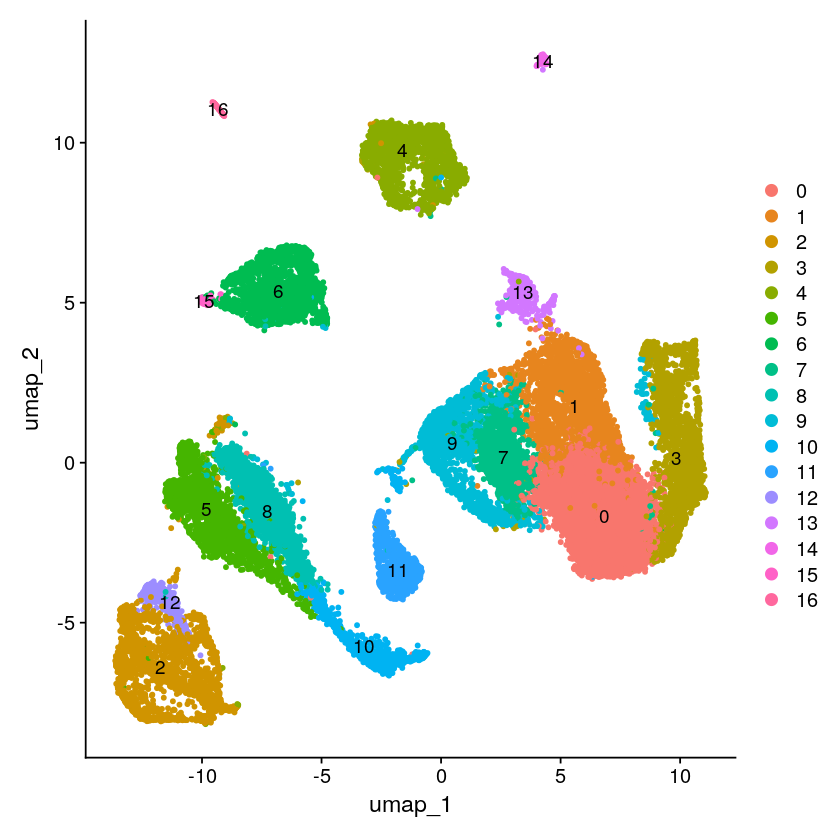

In [18]:
compute.one(
    timepoints[1],
    cluster_res = 0.5,
    cluster_dim = 30,
    genes_oi = genes_of_interest,
    hk_genes = housekeeping_genes,
    Umap = TRUE, Umap_p = TRUE,
    violin = TRUE, violin_p = TRUE,
    comp_hist = TRUE, comp_hist_p = TRUE,
    mark = TRUE, mark_p = TRUE,
    save = FALSE
)

save.my.thing <- function(
    thing_type,
    thing,
    image_resolution
) {
    res_list <- data.frame
    
    if (thing_type == "plot") {
        ggsave(
            paste0(
                
            ),
            file = umap_plot,
            width = 1920*, height = 1080*2, units = "px"
        )
    } else if (thing_type == "plot") {
        
    } else if (thing_type == "plot") {
        
    }
}

compute.all <- function(
    
) {
    
    
    print("Finished successfully")
}

for (time_point in 1:length(timepoints)) {
    print(paste("STARTING", timepoints[time_point], "- LOADING DATA"))

    # Load the data
    sc_data <- load.data(file_name = timepoints[time_point], save = TRUE)

    print(paste(timepoints[time_point], "- DATA LOADED, CLUSTERING"))
    # Run PCA and clustering
    sc_data <- PCA.cluster(sc_data, res = 1, n_dim = 40, save = TRUE)

    print(paste(timepoints[time_point], "- CLUSTERS DONE, STARTING WITH PLOTS"))

    print(paste(timepoints[time_point], "- VIOLINS"))
    # Violin Plots
    vin.all(
        g_oi = genes_of_interest,
        hk = housekeeping_genes
    )

    print(paste(timepoints[time_point], "- COMPARISON HISTOGRAMS"))
    # Comparison plots
    all.comparison.plot(
        g_oi = genes_of_interest,
        hk = housekeeping_genes
    )
    
    print(paste(timepoints[time_point], "- PLOTS DONE"))
    
    print(paste(timepoints[time_point], "- FIND ALL MARKERS"))
    # Find all markers
    cluster_markers <- cluster.markers(sc_data)

    print(paste(timepoints[time_point], "- DIFFERENTIAL EXPRESSION FOR GENES OF INTEREST"))
    # Find differentially expressed genes
    de_genes <- de.genes(genes_of_interest)

    print(paste(timepoints[time_point], "- END"))
}
print("Finished successfully")

for (aaa in 1:length(timepoints)) {
    compute.one(
        timepoints[aaa],
        cluster_res = 0.5,
        cluster_dim = 30,
        genes_oi = genes_of_interest,
        hk_genes = housekeeping_genes,
        Umap = TRUE, Umap_p = TRUE,
        violin = TRUE, violin_p = TRUE,
        comp_hist = TRUE, comp_hist_p = TRUE,
        mark = TRUE, mark_p = TRUE,
        save = TRUE
    )
}
print("Finished successfully")

ari pacchetto python per  confrontare quanto due cluster siano uguali